In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Optimizer():
    def __init__(self, max_step):
        self.param_history = []
        self.func_history = []
        self.max_step = max_step
    
    def clear(self):
        self.param_history = []
        self.func_history = []

    def GD(self, function, w, others, r, lr=1):
        # GD : gradient descent
        # function : Function
        # r : stop condition
        self.clear()
        tmp = np.copy(w)
        self.param_history.append(tmp)
        self.func_history.append(function.f(tmp, others))
        count = 0
        while count <= self.max_step:
            grads = function.grad(tmp, others)
            tmp = tmp-lr*grads
            self.param_history.append(tmp)
            self.func_history.append(function.f(tmp, others))
            if np.linalg.norm(grads, ord=2) < r:
                break
            count +=1
        
        return tmp           
                

    def Newton(self, function, w, others, r):
        # function : Function
        # r : stop condition
        self.clear()
        tmp = np.copy(w).flatten()
        self.param_history.append(tmp.reshape(w.shape))
        self.func_history.append(function.f(tmp.reshape(w.shape), others))
        count = 0
        while count < self.max_step:
            grads = function.grad(tmp.reshape(w.shape), others).flatten()
            hessians = function.hessian(tmp.reshape(w.shape), others)
            tmp = tmp-np.dot(np.linalg.pinv(hessians), grads)
            self.param_history.append(tmp.reshape(w.shape))
            self.func_history.append(function.f(tmp.reshape(w.shape), others))
            if np.linalg.norm(grads, ord=2) < r:
                break
            count +=1
        return tmp.reshape(w.shape)

In [3]:
class Function():
    # x : numpy.ndarray
    h = 1e-4
    def __init__(self):
        return

    def f(self, w, others):
        # It must be overridden
        # w : need grad
        # others : do not need grad
        return w

    def grad(self, w, others):
        # may be overridden if f' can be solved analytically
        tmp = 0
        grads = np.zeros_like(w, dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            fx1 = self.f(w, others)
            w[i] = tmp + self.h
            fx2 = self.f(w, others)
            grads[i] = (fx2-fx1)/(2*self.h)
            w[i] = tmp

        return grads

    def hessian(self, w, others):
        tmp = 0
        hessians = np.zeros([w.size, w.size], dtype=float)
        for i in range(w.size):
            tmp = w[i]
            w[i] = tmp - self.h
            grads1 = self.grad(w, others)
            w[i] = tmp + self.h
            grads2 = self.grad(w, others)
            hessians[:, i] = (grads2-grads1)/(2*self.h)
            w[i] = tmp

        return hessians

In [4]:
class P1F(Function):
    def __init__(self, lamb=0.01):
        self.lamb = lamb
    
    def f(self, w, others):
        # others : [[list of x], [list of y]]
        # list of x : np.array(np.ndarray, np.ndarray, ...)
        # list of y : [int, int, int, int, ...]
        # x is int
        res = 0
        xs = others[0]
        ys = others[1]
        for x, y in zip(xs, ys):
            res += np.log(1+np.exp(-y*np.dot(w, x)))
        
        res += self.lamb*np.dot(w, w)
        return res

    # def grad(self, w, others):
    #     xs = others[0]
    #     ys = others[1]
    #     grads = np.zeros_like(w, dtype=float)
    #     for x, y in zip(xs, ys):
    #         tmp = (np.exp(-y*np.dot(w, x))*(-y*x))/(1+np.exp(-y*np.dot(w, x)))
    #         grads += tmp

    #     grads += 2*self.lamb*w

    #     return grads

In [5]:
def plot_result(w, history, title):
    fig,ax = plt.subplots()
    ax.plot(list(range(len(history[1]))), history[1])
    ax.set_title(title)
    plt.show()

def plot_performance(ws, histories, titles, opt, sizes):
    fig,ax = plt.subplots(1, len(ws), figsize=sizes)
    for i in range(len(ws)):
        ax[i].plot(list(range(len(histories[i][1]))), histories[i][1]-opt)
        ax[i].set_title(titles[i])
        ax[i].set_ylim(bottom=0)
    plt.show()

In [6]:
# making dataset IV
np.random.seed(0)
n = 200
#[[x0], [x1], [x2], ...]
x = 3*(np.random.rand(n,4)-0.5)
y = (2*x[:, 0] - x[:, 1] + 0.5 + 0.5*np.random.randn(n)) > 0
y = 2*y-1

In [7]:
np.random.seed(1)
w = np.random.rand(4)
p1f = P1F()
optimizer = Optimizer(1024)

In [8]:
# 1
w_opt_g = optimizer.GD(function=p1f, w=w, others=[x, y], r=0.01, lr=1e-3)
print(w_opt_g)
history_g = [optimizer.param_history, optimizer.func_history]

[ 4.0749956  -1.87087528 -0.1698198  -0.27886255]


In [9]:
# 2
w_opt_n = optimizer.Newton(function=p1f, w=w, others=[x, y], r=0.01)
print(w_opt_n)
history_n = [optimizer.param_history, optimizer.func_history]

[ 4.25888853 -1.97731083 -0.17749302 -0.28179864]


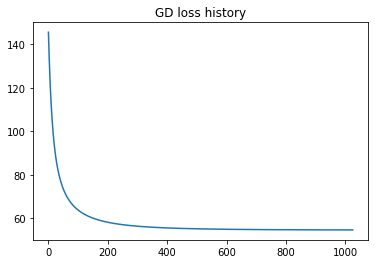

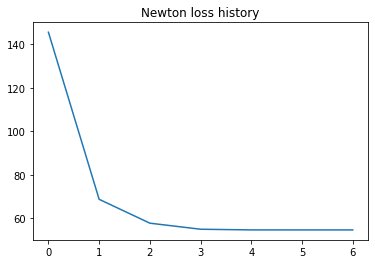

In [10]:
plot_result(w_opt_g, history_g, 'GD loss history')
plot_result(w_opt_n, history_n, 'Newton loss history')

In [11]:
f_g = p1f.f(w_opt_g, [x,y])
f_n = p1f.f(w_opt_n, [x,y])
print('GD     : ', f_g)
print('Newton : ', f_n)

GD     :  54.736116156134784
Newton :  54.68890021609999


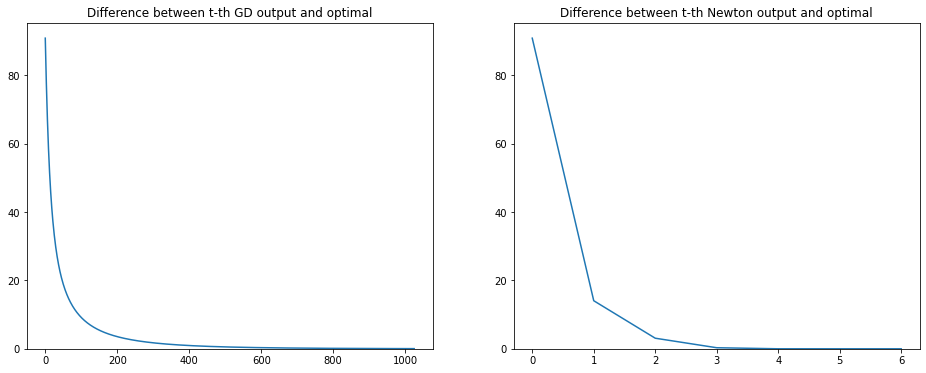

In [12]:
#3
ws = [w_opt_g, w_opt_n]
histories = [history_g, history_n]
titles = ['Difference between t-th GD output and optimal', 'Difference between t-th Newton output and optimal']
sizes = [16, 6]
plot_performance(ws, histories, titles, f_n, sizes)

In [13]:
# making dataset V
n = 200
np.random.seed(3)
x = 3 * (np.random.rand(n, 4) - 0.5)
W = np.array([[ 2,  -1, 0.5,],
              [-3,   2,   1,],
              [ 1,   2,   3]])
y = np.argmax(np.dot(np.hstack([x[:,:2], np.ones((n, 1))]), W.T)
                        + 0.5 * np.random.randn(n, 3), axis=1)

In [14]:
def softmax(a):
    # a : numpy.ndarray
    # m : float
    m = a.max()
    return np.exp(a-m)/np.exp(a-m).sum()

def to_one_hot(arrays, num_class):
    res = np.zeros([len(arrays), num_class])
    for i in range(len(arrays)):
        res[i][arrays[i]] = 1
    
    return res

class P1FMulti(Function):
    eps = 1e-4
    def __init__(self):
        return
    
    def f(self, w, others):
        # average softmax cross entropy
        # w : [[param0], [param1], ..., [paramn]]
        # ys.size : dataset size
        xs = others[0]
        ys = others[1]
        res = 0
        for i in range(ys.size):
            loss = softmax(np.dot(w, xs[i]))
            res -= np.log(loss[y[i]]+self.eps)
        
        res /= ys.size
        return res                

    def grad_oneparam(self, w, others, i):
        tmp = 0
        grads = np.zeros_like(w[i])
        for j in range(w[i].size):
            tmp = w[i][j]
            w[i][j] = tmp - self.h
            fx1 = self.f(w, others)
            w[i][j] = tmp + self.h
            fx2 = self.f(w, others)
            grads[j] = (fx2-fx1)/(2*self.h)
            w[i][j] = tmp
        return grads

    def grad(self, w, others):
        tmp = 0
        grads = np.zeros_like(w, dtype=float)
        for i in range(w.shape[0]):
            grads[i] = self.grad_oneparam(w, others, i)
        return grads

    def hessian(self, w, others):
        # res
        M = w.shape[1]
        K = w.shape[0]
        hessians = np.zeros([M*K, M*K])
        for i in range(K):
            for j in range(K):
                tmp = 0
                Hij = np.zeros([M, M])
                for k in range(w[j].size):
                    tmp = w[j][k]
                    w[j][k] = tmp - self.h
                    grads1 = self.grad_oneparam(w, others, i)
                    w[j][k] = tmp + self.h
                    grads2 = self.grad_oneparam(w, others, i)
                    Hij[:, k] = (grads2-grads1)/(2*self.h)
                    w[j][k] = tmp
                hessians[i*M:(i+1)*M, j*M:(j+1)*M] = Hij
        return hessians

In [15]:
p1fm = P1FMulti()

In [16]:
K = 3
M = 4
np.random.seed(3)
w = np.random.rand(K,M)

In [17]:
w_opt_g = optimizer.GD(function=p1fm, w=w, others=[x, y], r=0.01, lr=1e-2)
print(w_opt_g)
history_g = [optimizer.param_history, optimizer.func_history]

[[ 0.94827583 -0.12580955  0.15227883  0.47075078]
 [-0.87630274  0.82686055  0.11551731  0.459198  ]
 [ 1.42323897  1.34419976  0.17857012  0.24495492]]


In [18]:
w_opt_n = optimizer.Newton(function=p1fm, w=w, others=[x, y], r=0.01)
print(w_opt_n)
history_n = [optimizer.param_history, optimizer.func_history]

[[ 1.46789522 -3.15688653  0.03558815 -1.17654455]
 [-2.09020624 -1.71866837  0.16869407 -0.91824671]
 [ 2.80265389 -0.25971671  0.37152337 -1.43778665]]


In [19]:
f_g = p1fm.f(w_opt_g, [x,y])
f_n = p1fm.f(w_opt_n, [x,y])
print('GD     : ', f_g)
print('Newton : ', f_n)

GD     :  0.5600386798331689
Newton :  0.4703922894714026


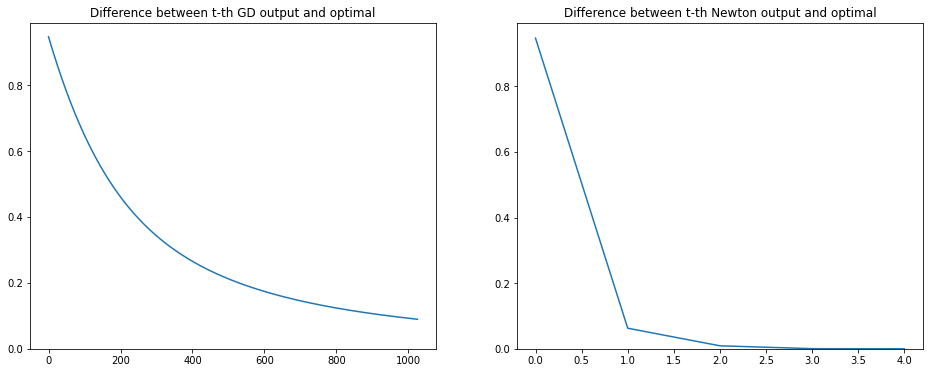

In [21]:
ws = [w_opt_g, w_opt_n]
histories = [history_g, history_n]
titles = ['Difference between t-th GD output and optimal', 'Difference between t-th Newton output and optimal']
sizes = [16, 6]
plot_performance(ws, histories, titles, f_n, sizes)